# Read Data Sample

In [10]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows",15)
%matplotlib inline

In [11]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")

In [12]:
dataset.kdd_train_2labels.shape

(125973, 123)

In [13]:
dataset.kdd_test_2labels.shape

(22544, 123)

In [14]:
import tensorflow as tf

sess = tf.InteractiveSession()

In [15]:
class network:
    tf.reset_default_graph()

    input_dim = 121
    classes = 2
    hidden_encoder_dim = 40

    latent_dim = 10

    hidden_decoder_dim = 40

    lam = 0.01

    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.001)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.constant(0.01, shape=shape)
        return tf.Variable(initial)

    l2_loss = tf.constant(0.001)
    #learning_rate = tf.Variable(initial_value=0.001)

    with tf.variable_scope("Input"):
        x = tf.placeholder("float", shape=[None, input_dim])
        y_ = tf.placeholder("float", shape=[None, classes])

        keep_prob = tf.placeholder("float")

    with tf.variable_scope("Layer_Encoder"):
        W_encoder_input_hidden = weight_variable([input_dim,hidden_encoder_dim])
        b_encoder_input_hidden = bias_variable([hidden_encoder_dim])
        l2_loss += tf.nn.l2_loss(W_encoder_input_hidden)

        # Hidden layer encoder
        hidden_encoder = tf.nn.relu(tf.matmul(x, W_encoder_input_hidden) + b_encoder_input_hidden)
        tf.summary.histogram("Weights_Encoder", W_encoder_input_hidden)
        hidden_encoder = tf.nn.dropout(hidden_encoder, keep_prob=keep_prob)

    with tf.variable_scope("Layer_Mean"):
        W_encoder_hidden_mu = weight_variable([hidden_encoder_dim,latent_dim])
        b_encoder_hidden_mu = bias_variable([latent_dim])
        l2_loss += tf.nn.l2_loss(W_encoder_hidden_mu)

        # Mu encoder
        mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + b_encoder_hidden_mu
        tf.summary.histogram("Weights_Mean", W_encoder_hidden_mu)

    with tf.variable_scope("Layer_Variance"):
        W_encoder_hidden_logvar = weight_variable([hidden_encoder_dim,latent_dim])
        b_encoder_hidden_logvar = bias_variable([latent_dim])
        l2_loss += tf.nn.l2_loss(W_encoder_hidden_logvar)

        # Sigma encoder
        logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + b_encoder_hidden_logvar
        tf.summary.histogram("Weights_Variance", W_encoder_hidden_logvar)

    with tf.variable_scope("Sampling_Distribution"):
        # Sample epsilon
        epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')

        # Sample latent variable
        std_encoder = tf.exp(0.5 * logvar_encoder)
        z = mu_encoder + tf.multiply(std_encoder, epsilon)
        tf.summary.histogram("Sample_Distribution", z)

    with tf.variable_scope("Layer_Decoder"):
        W_decoder_z_hidden = weight_variable([latent_dim,hidden_decoder_dim])
        b_decoder_z_hidden = bias_variable([hidden_decoder_dim])
        l2_loss += tf.nn.l2_loss(W_decoder_z_hidden)

        # Hidden layer decoder
        hidden_decoder = tf.nn.relu(tf.matmul(z, W_decoder_z_hidden) + b_decoder_z_hidden)
        hidden_decoder = tf.nn.dropout(hidden_decoder, keep_prob=keep_prob)
        tf.summary.histogram("Weights_Decoder", W_decoder_z_hidden)

    with tf.variable_scope("Layer_Reconstruction"):
        W_decoder_hidden_reconstruction = weight_variable([hidden_decoder_dim, input_dim])
        b_decoder_hidden_reconstruction = bias_variable([input_dim])
        l2_loss += tf.nn.l2_loss(W_decoder_hidden_reconstruction)

        x_hat = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) + b_decoder_hidden_reconstruction
        tf.summary.histogram("Weights_Reconstruction", W_decoder_hidden_reconstruction)

    with tf.variable_scope("Layer_Dense_Hidden"):
        hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

    with tf.variable_scope("Layer_Dense_Softmax"):
        y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

    with tf.variable_scope("Loss"):
        BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=x), reduction_indices=1)
        KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
        softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))

        loss = tf.reduce_mean(BCE + KLD + softmax_loss)

        regularized_loss = tf.abs(loss + lam * l2_loss, name = "Regularized_loss")
        correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
        tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        #tf.summary.scalar("BCE", BCE)
        #tf.summary.scalar("KLD", KLD)
        #tf.summary.scalar("Softmax_loss", softmax_loss)

        tf.summary.scalar("loss", regularized_loss)



    with tf.variable_scope("Optimizer"):
        learning_rate=0.001
        grad_clip=5
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(regularized_loss, tvars), grad_clip)
        train_op = tf.train.AdamOptimizer(learning_rate)
        optimizer = train_op.apply_gradients(zip(grads, tvars))

    # add op for merging summary
    summary_op = tf.summary.merge_all()
    pred = tf.argmax(y, 1)
    actual = tf.argmax(y_, 1)


    # add Saver ops
    # saver = tf.train.Saver()

In [16]:
class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']

    from sklearn import model_selection as ms
    from sklearn import preprocessing as pp

    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]


    ss = pp.StandardScaler()

    x_input = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)


    x_train, x_valid, y_train, y_valid = ms.train_test_split(x_input, 
                                  y_output.values, 
                                  test_size=0.33)


In [17]:
class Hyperparameters:
    features_arr = [4, 8, 16, 32, 64, 128]
    hidden_layers_arr = [2, 4, 6, 8]
    

In [ ]:
epochs = 50
batch_iterations = 100

batch_indices = np.array_split(np.arange(preprocess.x_train.shape[0]), 
                               batch_iterations)

with tf.Session() as sess:
    summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
    summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

    sess.run(tf.global_variables_initializer())

    for epoch in range(0, epochs):
        for i in batch_indices:
            _, train_loss, summary_str = sess.run([network.optimizer, 
                                                   network.regularized_loss, 
                                                   network.summary_op],
                                                  feed_dict={network.x: preprocess.x_train[i,:], 
                                                             network.y_: preprocess.y_train[i,:], 
                                                             network.keep_prob:0.6})
            summary_writer_train.add_summary(summary_str, epoch)

        
        accuracy, summary_str = sess.run([network.tf_accuracy, network.summary_op], 
                                              feed_dict={network.x: preprocess.x_valid, 
                                                         network.y_: preprocess.y_valid, 
                                                         network.keep_prob:1})
        summary_writer_valid.add_summary(summary_str, epoch)
            
        if epoch % 10 == 0:
            print("Step {} | Training Loss: {:.4f} | Validation Accuracy: {:.4f}".format(epoch, train_loss, accuracy))
            
    accuracy, pred_value, actual_value = sess.run([network.tf_accuracy, 
                                                   network.pred, 
                                                   network.actual], 
                                                  feed_dict={network.x: preprocess.x_test, 
                                                             network.y_: preprocess.y_test, 
                                                             network.keep_prob:1})
    
    
    print("Accuracy on Test data: {}".format(accuracy))

Step 0 | Training Loss: 0.9696 | Validation Accuracy: 0.8966
Step 10 | Training Loss: 0.0884 | Validation Accuracy: 0.9144
Step 20 | Training Loss: 0.0197 | Validation Accuracy: 0.9118
Step 30 | Training Loss: 0.0168 | Validation Accuracy: 0.9081
Step 40 | Training Loss: 0.0298 | Validation Accuracy: 0.9067


In [10]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.5836  0.4164]
 [ 0.0498  0.9502]]


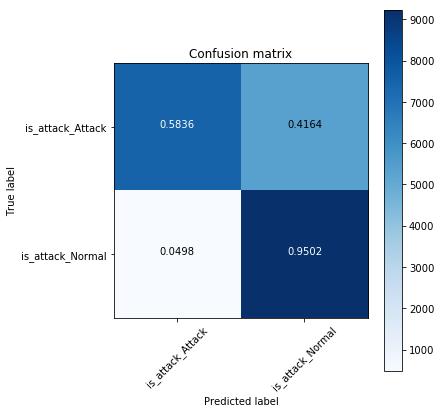

In [12]:
from sklearn.metrics import confusion_matrix
cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
plt.figure(figsize=[6,6])
plot_confusion_matrix(cm_2labels, output_columns_2labels, normalize = True)